In [2]:
from deepface import DeepFace
from deepface.models.demography import Emotion, Gender, Race

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image
from skimage.segmentation import mark_boundaries

import tensorflow as tf

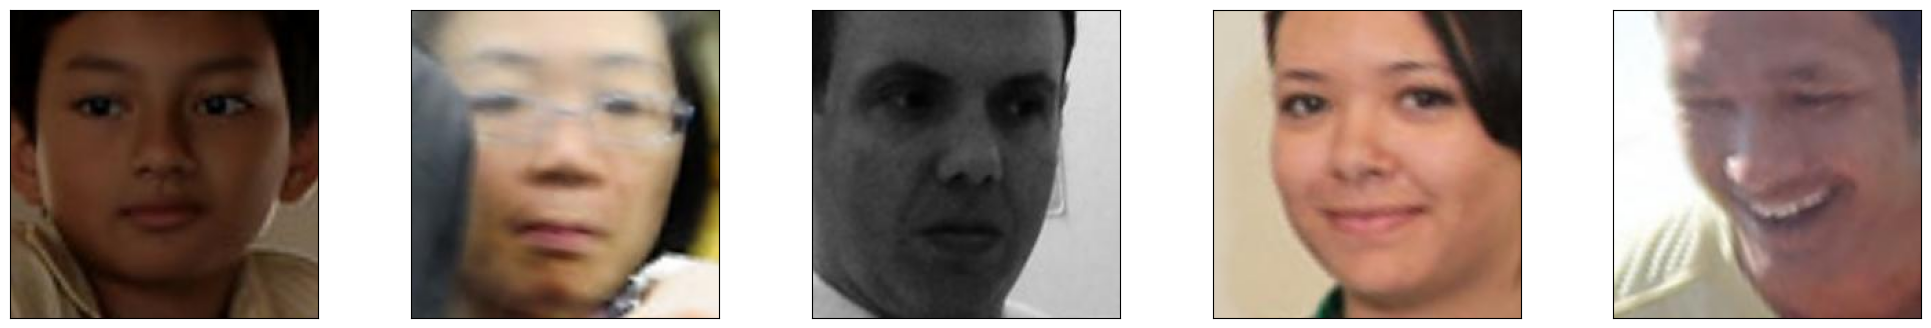

In [6]:
def get_image(path):
    with open(os.path.abspath('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/images/' + path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
#get all .jpeg files in the data folder
#images = [get_image(i) for i in os.listdir('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/images') if i.endswith('.jpg')]
images = [get_image('{}.jpg'.format(i)) for i in range(1,101)]

# plot the images
fig = plt.figure(figsize=(25, 4))
for idx, img in enumerate(images):
    if idx > 4:
        break
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img)

In [3]:
model_emotion = Emotion.load_model()
model_gender = Gender.load_model()
model_race = Race.load_model()

In [20]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model_gender(input_image)
        print(input_label)
        print(prediction)
        loss = loss_object(input_label, prediction)
        
        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        return signed_grad

1/1 [==============================] - 0s 15ms/step
tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[9.9935037e-01 6.4957904e-04]], shape=(1, 2), dtype=float32)


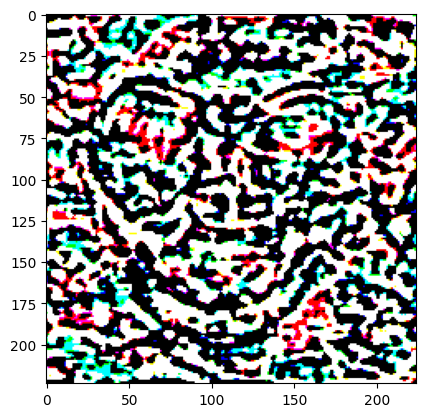

In [76]:
img_indx = 49

gender_predictions = model_gender.predict(np.array(images[img_indx])[None,:])
race_predictions = model_race.predict(np.array(images[img_indx])[None,:])
#emotion_predictions = model_emotion.predict(np.array(images[img_indx])[None,:])

image = tf.convert_to_tensor(np.array(images[img_indx])[None,:]) / 255
# Get the input label of the image.
index = 0
label = tf.convert_to_tensor(gender_predictions)

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [77]:
def display_images(image, description, idx2label, num, eps):
    prediction = np.array(model_gender.predict(image))
    confidence = np.max(prediction)
    label = idx2label[np.argmax(prediction)]
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.xticks([])
    plt.yticks([])
    plt.savefig("FGSM_results/gender_" + str(num) + "_" + str(eps) + ".png", bbox_inches="tight")
    plt.show()

1/1 [==============================] - 0s 15ms/step


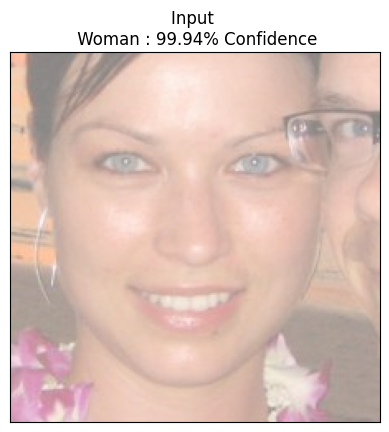

1/1 [==============================] - 0s 15ms/step


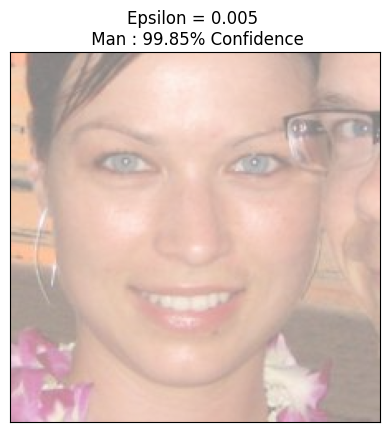

1/1 [==============================] - 0s 13ms/step


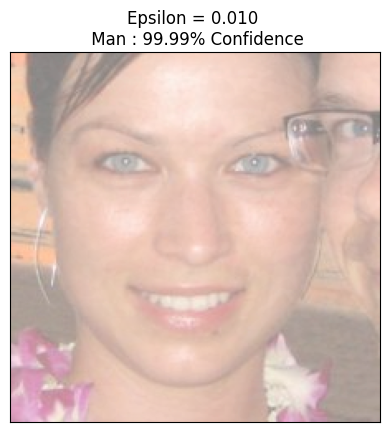

1/1 [==============================] - 0s 14ms/step


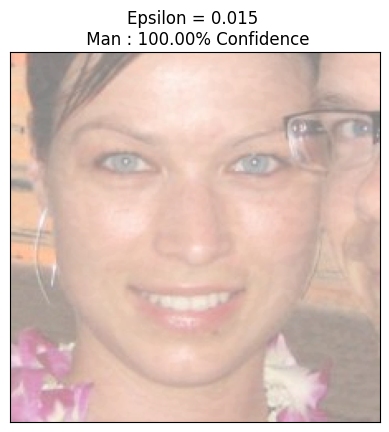

In [78]:
idx2label = ["Woman", "Man"]
epsilons = [0, 0.005, 0.01, 0.015]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i], idx2label, img_indx, i)
